In [52]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [53]:
# load up and prepare corpus

# load my corpus of interest - All New York Times articles published '80-'89 that mention Vietnam
nyt80s = pandas.read_csv('../data/nyt80s.csv')

# prepare

nyt80s['tokenized_sents'] = nyt80s['article'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
nyt80s['normalized_sents'] = nyt80s['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

nyt80sW2V = gensim.models.word2vec.Word2Vec(nyt80s['normalized_sents'].sum())

nyt80sW2V.wv.syn0

array([[ 1.6825147e+00,  6.9323617e-01,  1.4560804e+00, ...,
         2.0453668e+00, -4.4930902e-01,  1.5013618e+00],
       [ 6.7060471e-02, -3.7718777e-02,  9.9084342e-01, ...,
         1.9959071e+00,  1.1143116e+00,  8.5802674e-02],
       [ 6.4755791e-01,  1.2168905e-02,  2.2829731e-01, ...,
         2.4460402e+00,  1.8995866e+00,  1.0483687e+00],
       ...,
       [ 1.7472990e-02,  4.7673468e-02,  1.2499005e-02, ...,
         5.6495187e-03,  8.0783041e-03, -9.1362401e-04],
       [-3.6470886e-02, -1.9066673e-02, -6.2952474e-02, ...,
         2.4548832e-02, -4.7455076e-02, -2.0168340e-02],
       [-3.7056446e-02,  4.3880079e-02, -4.5044586e-02, ...,
         3.8825229e-02, -6.8485968e-02, -1.6156930e-02]], dtype=float32)

In [54]:
#words to create dimensions
tnytTargetWords = ['reagan','carter','nixon', 'ford', 'republican', 'democrat', 'liberal', 'conservative', 'man', 'woman']
#words we will be mapping
tnytTargetWords += ["soldier","servicemen","captivity","missing", 'veteran', 'iran', 'soviet', 'ussr', 'cold', 'contras', 'nicaragua']


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nyt80sW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 1.1184732 , -1.0071257 , -0.8926199 , ..., -1.980782  ,
         3.6218836 ,  1.1174778 ],
       [ 0.70074123,  0.14369375,  1.0333239 , ..., -2.9811773 ,
         1.7560173 ,  1.3681792 ],
       [ 0.65099114, -1.1729565 ,  2.3527672 , ..., -1.1629657 ,
         0.8826279 ,  1.3710153 ],
       ...,
       [-0.81716925, -0.5864443 ,  0.17102568, ...,  0.9606561 ,
        -1.6194324 ,  0.6483456 ],
       [ 0.32768223,  1.327721  ,  0.54920834, ...,  0.9494521 ,
         1.6400104 , -0.22581528],
       [ 0.9628595 ,  0.598207  ,  0.4780752 , ...,  1.7455019 ,
         0.4634932 ,  0.39081153]], dtype=float32)

In [55]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

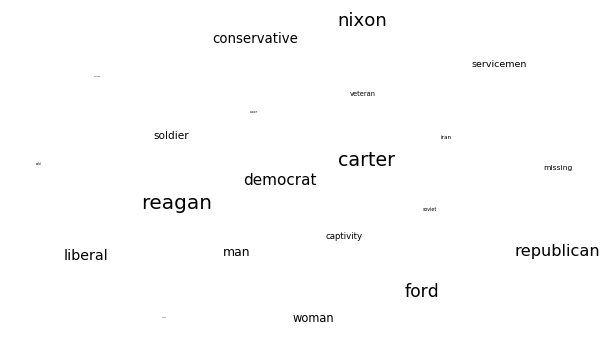

In [56]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [57]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [58]:
# for this exercise, I'm going to explore two (somewhat) different discursive formations 
# that ought to appear in my corpus: a discussion about soldiers, veterans, POWs, and MIAs,
# and larger foreign policy issues. Although the nature of my corpus means the first
# formation will be better  represented, it might be interesting to see the general portrayl
# of Vietnam in NYT articles in the 1980s related to foreign policy.

# I'll explore along three dimensions: administrationa, party, and,
# out of curiosity: gender. 

In [59]:
Administration = dimension(nyt80sW2V, ['reagan'], ['carter'])

Party = dimension(nyt80sW2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt80sW2V, ['man'], ['woman'])

In [60]:

VietnamWar = ['soldier', 'soldiers', 'servicemen', 'veteran', 'captivity', 'missing']

ForeignPolicy = ['iran', 'soviet', 'ussr', 'cold', 'contras', 'nicaragua']



In [61]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nyt80sW2V[word].reshape(1,-1), Administration.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nyt80sW2V[word].reshape(1,-1), Party.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nyt80sW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'administration': g, 'party': r, 'gender': c}, index = word_list)
    return df

In [62]:
vietnamWarDF = makeDF(nyt80sW2V, VietnamWar) 
foreignPolicyDF = makeDF(nyt80sW2V, ForeignPolicy)

In [63]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [64]:
# Below, we can see the results of my test. I'll highlight just a few of the 
# results. We can see that 'soldiers' were more associated with Reagan, while 
# captivity was more associated with Carter (though this is probably due to 
# the Iran hostage crisis. Along the party dimension, however, captivity and missing 
# hold a central-moderate position. Soldiers are still conservative.
# Interesting, captivity, servicemen, and missing are more closely related to the
# female end of my gender dimension. 

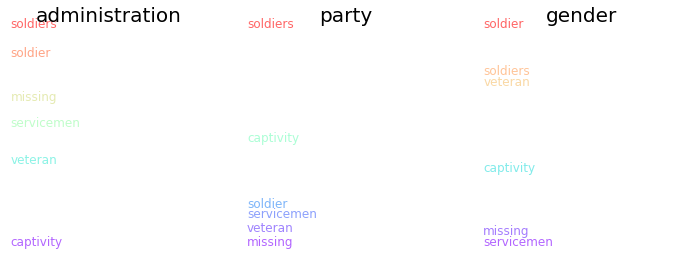

In [65]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, vietnamWarDF, 'administration')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, vietnamWarDF, 'party')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, vietnamWarDF, 'gender')
plt.show()

In [66]:
# Nicaragua is more related to Reagan, while Iran is more related to Carter.
# No surprises there! THough, interestingly, the Contras only slightly favor 
# the Reagan end of the pole.
# Interestingly, the Contras are still centralized, and now Nicaragua tends
# towards the democratic end of the pole under the party dimension.
# Very interestingly, almost all words cluster toward the male end of the 
# gender dimension. I interpret this to indicate that the 'foreign policy'
# game is often conceived of, and articulated in, male gendered terms. 
# This finding would compliment Laura Sjoberg (2013) work on the gendered terms
# of international politics theorizing. 


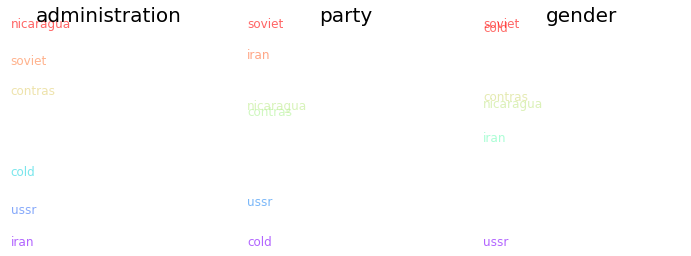

In [67]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, foreignPolicyDF, 'administration')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, foreignPolicyDF, 'party')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, foreignPolicyDF, 'gender')
plt.show()